We have two gym wrappers that calculate sparse rewards at the end of the episode.

**relativeReward** calculates sum of attacker reward divided by sum of all rewards.

**rewardPerProgress** calculates sum of attacker reward divided by progress of the longest chain.

Hypothesis 1: The wrappers are equivalant for protocols that hand out a constant reward per progress. The canonical example is Bitcoin/Nakamoto, but one could also run this on Tailstorm with 'constant' reward scheme.

Hypothesis 2: The **rewardPerProgress** wrapper captures the effect of Tailstorm's 'discount' reward scheme, where some puzzle solutions get smaller rewards.

In [1]:
from cpr_gym import protocols, wrappers
import itertools
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [2]:
def env_fn(alpha, proto=protocols.nakamoto(), steps=2016):
    env = gym.make(
        "cpr_gym:core-v0", proto=proto, alpha=alpha, activation_delay=1, max_steps=steps
    )
    return env


def episode(env, policy="honest"):
    p = lambda obs: env.policy(obs, policy)
    obs = env.reset()
    done = False
    while not done:
        obs, reward, done, info = env.step(p(obs))
    return reward


def measure(
    alpha,
    proto=protocols.nakamoto(),
    policy="honest",
    steps_per_episode=2000,
    steps=5000,
    wrapper=lambda x: x,
):
    env = wrapper(env_fn(alpha, proto=proto, steps=steps_per_episode))
    # run measurements
    reward = []
    for i in range(int(np.ceil(steps / steps_per_episode))):
        try:
            r = episode(env, policy)
            reward.append(r)
        except ValueError as e:
            warnings.warn(e)
    return np.mean(reward)

In [3]:
alpha = np.arange(0.1, 1.05, 0.1)
spe = [8, 16, 32, 64, 128]
wrap = dict(
    sparseRelativeReward=wrappers.SparseRelativeRewardWrapper,
    sparseRewardPerProgress=wrappers.SparseRewardPerProgressWrapper,
)
protos = dict(
    nakamoto=protocols.nakamoto(),
    tailstorm8constant=protocols.tailstorm(k=8, reward="constant"),
    tailstorm8discount=protocols.tailstorm(k=8, reward="discount"),
)
dfs = []
for proto_s, proto in protos.items():
    env = env_fn(0.33, proto=proto)
    df = pd.DataFrame(
        itertools.product([proto_s], alpha, spe, wrap, env.policies()),
        columns=["protocol", "alpha", "steps_per_episode", "wrapper", "policy"],
    )
    df["reward"] = df.apply(
        lambda x: measure(
            x.alpha,
            proto=protos[x.protocol],
            policy=x.policy,
            steps_per_episode=x.steps_per_episode,
            wrapper=wrap[x.wrapper],
        ),
        axis=1,
    )
    dfs.append(df)
d = pd.concat(dfs, ignore_index=True)
d

,protocol,alpha,steps_per_episode,wrapper,policy,reward
0,nakamoto,0.1,8,sparseRelativeReward,sapirshtein-2016-sm1,0.066971
1,nakamoto,0.1,8,sparseRelativeReward,eyal-sirer-2014,0.080038
2,nakamoto,0.1,8,sparseRelativeReward,simple,0.077229
3,nakamoto,0.1,8,sparseRelativeReward,honest,0.094600
4,nakamoto,0.1,8,sparseRewardPerProgress,sapirshtein-2016-sm1,0.072836
...,...,...,...,...,...,...
1195,tailstorm8discount,1.0,128,sparseRelativeReward,honest,1.000000
1196,tailstorm8discount,1.0,128,sparseRewardPerProgress,override-catchup,1.000000
1197,tailstorm8discount,1.0,128,sparseRewardPerProgress,override-block,1.000000
1198,tailstorm8discount,1.0,128,sparseRewardPerProgress,release-block,1.000000


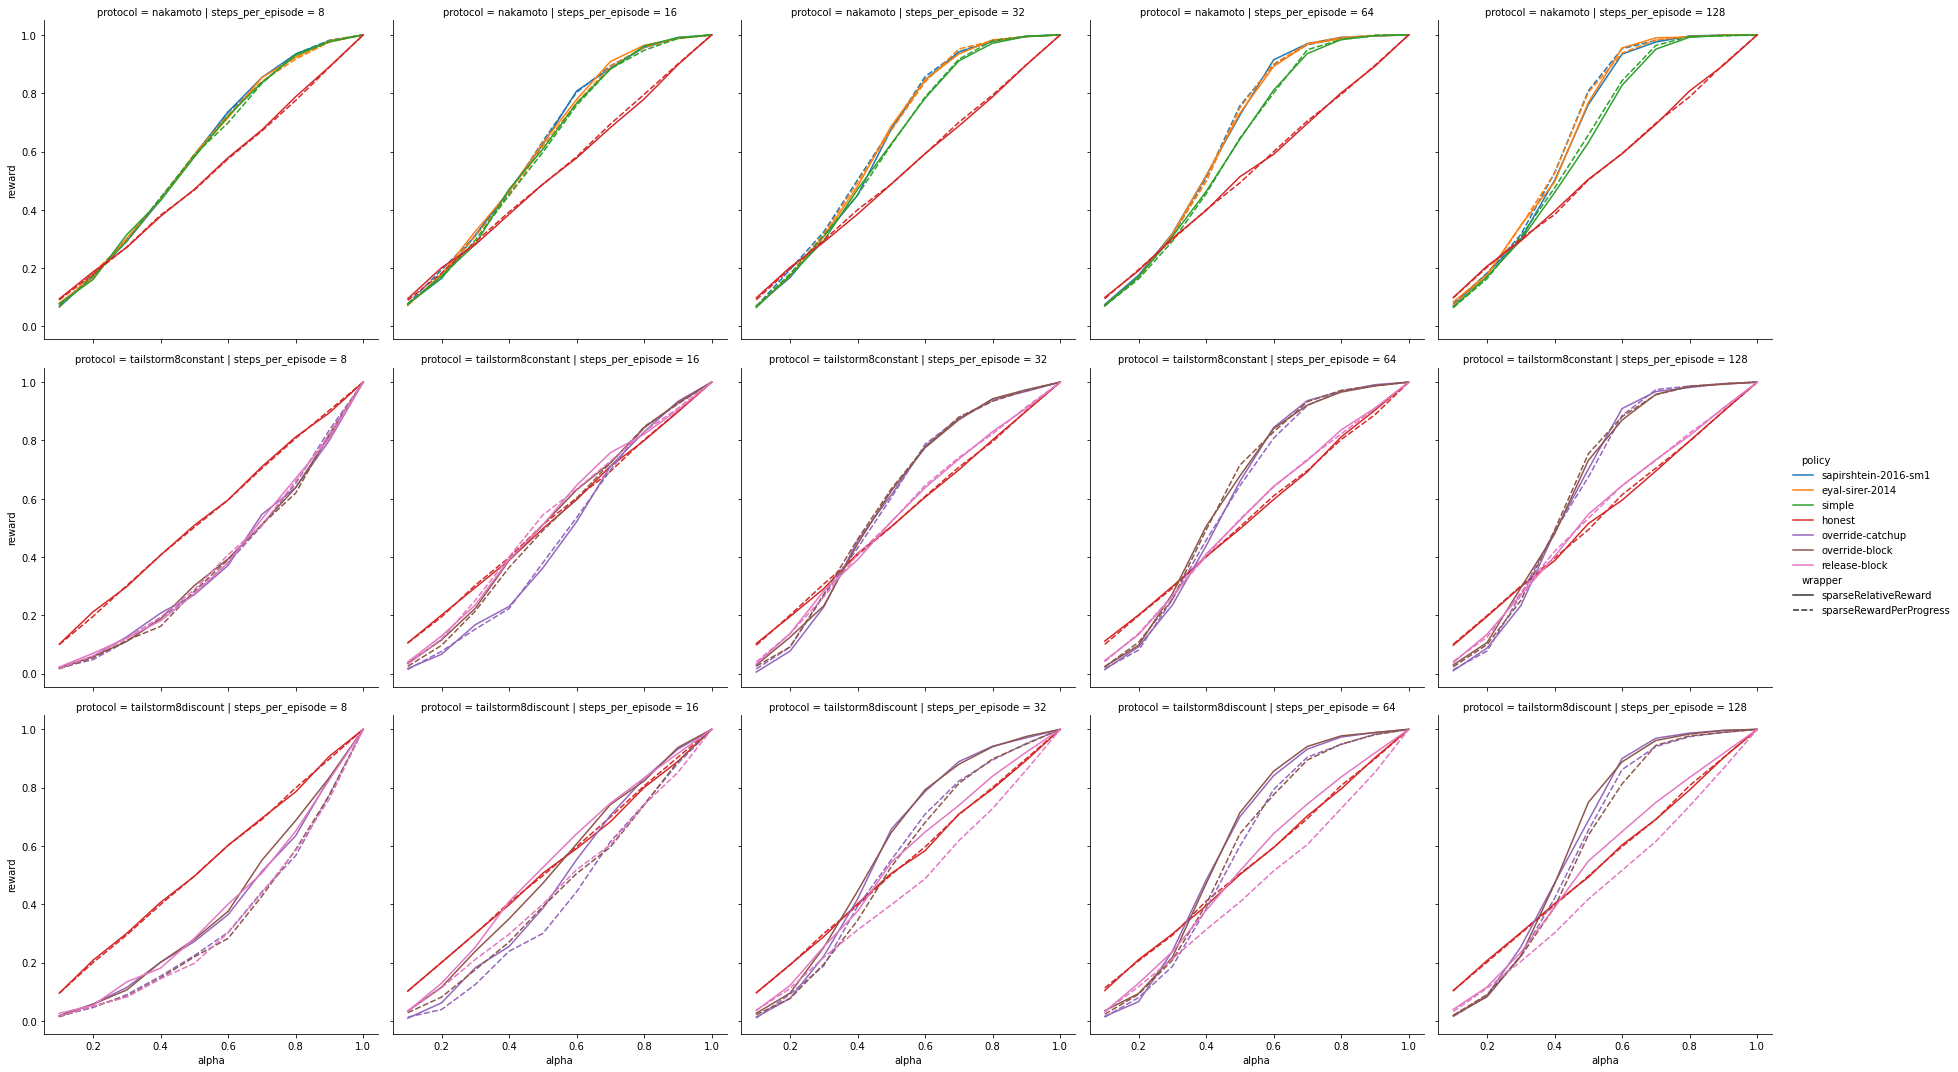

In [4]:
sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    style="wrapper",
    col="steps_per_episode",
    row="protocol",
)

This plot confirms Hypothesis 1. For Nakamoto and Tailstorm with constant reward, both wrappers produce the same results.

The plot supports Hypothesis 2. For Tailstorm with discount reward, the **rewardPerProgress** wrapper produces smaller rewards.

---
The following plots are for comparing the effect of steps_per_episode on Nakamoto. It seems that we have to train on steps_per_episode greater equal 64, in order to discover optimal selfish mining.

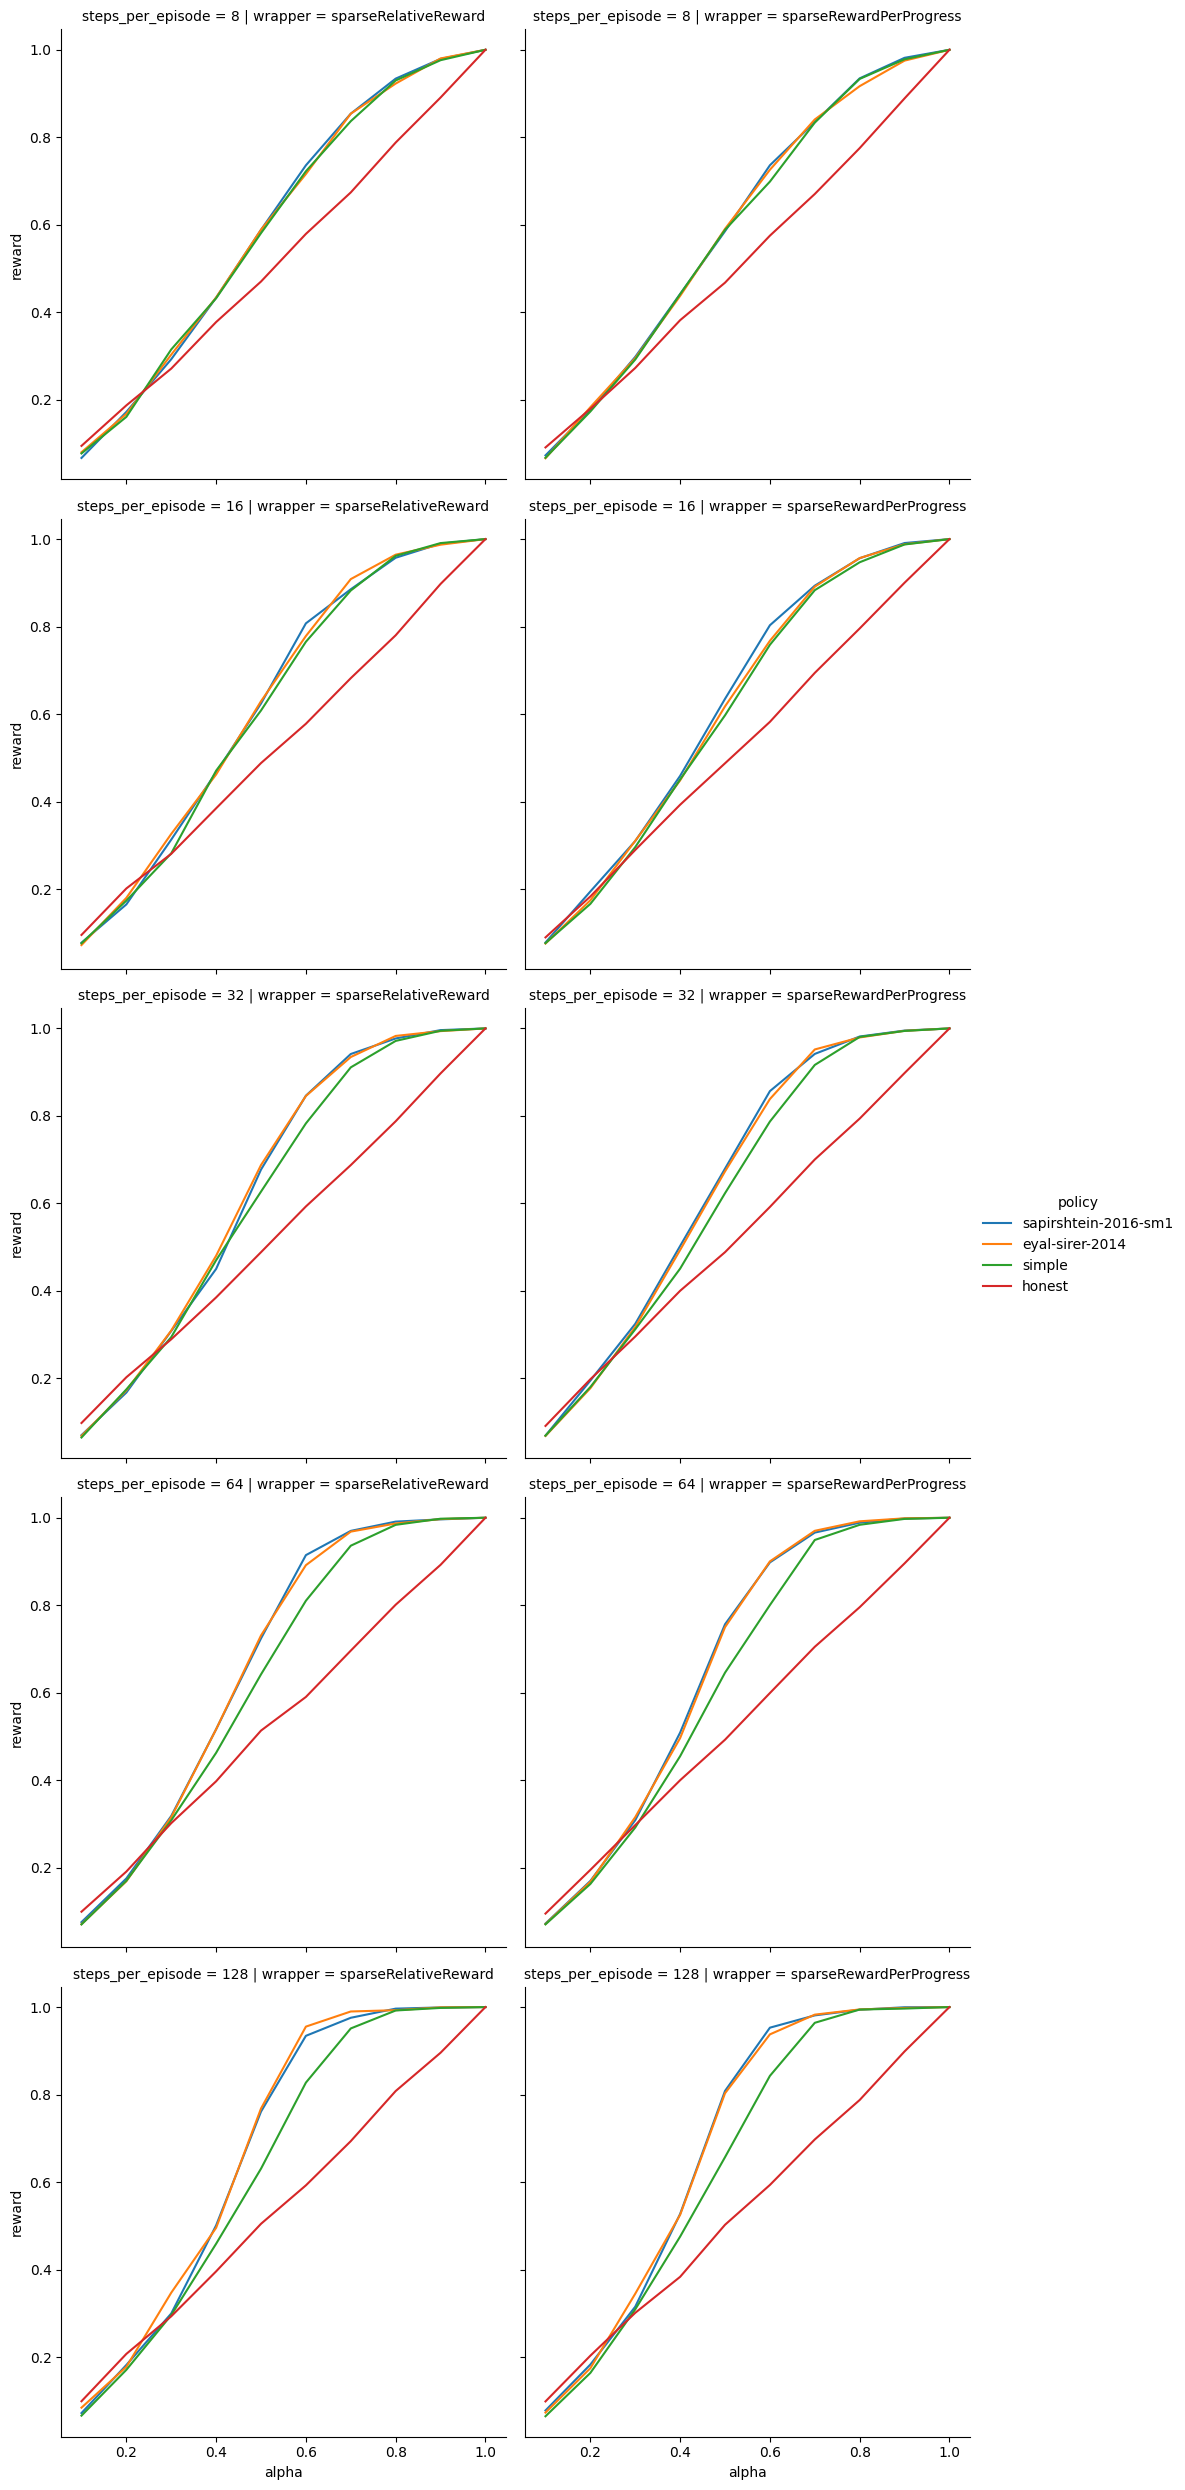

In [5]:
sns.relplot(
    data=d[d.protocol == "nakamoto"],
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    col="wrapper",
    row="steps_per_episode",
)

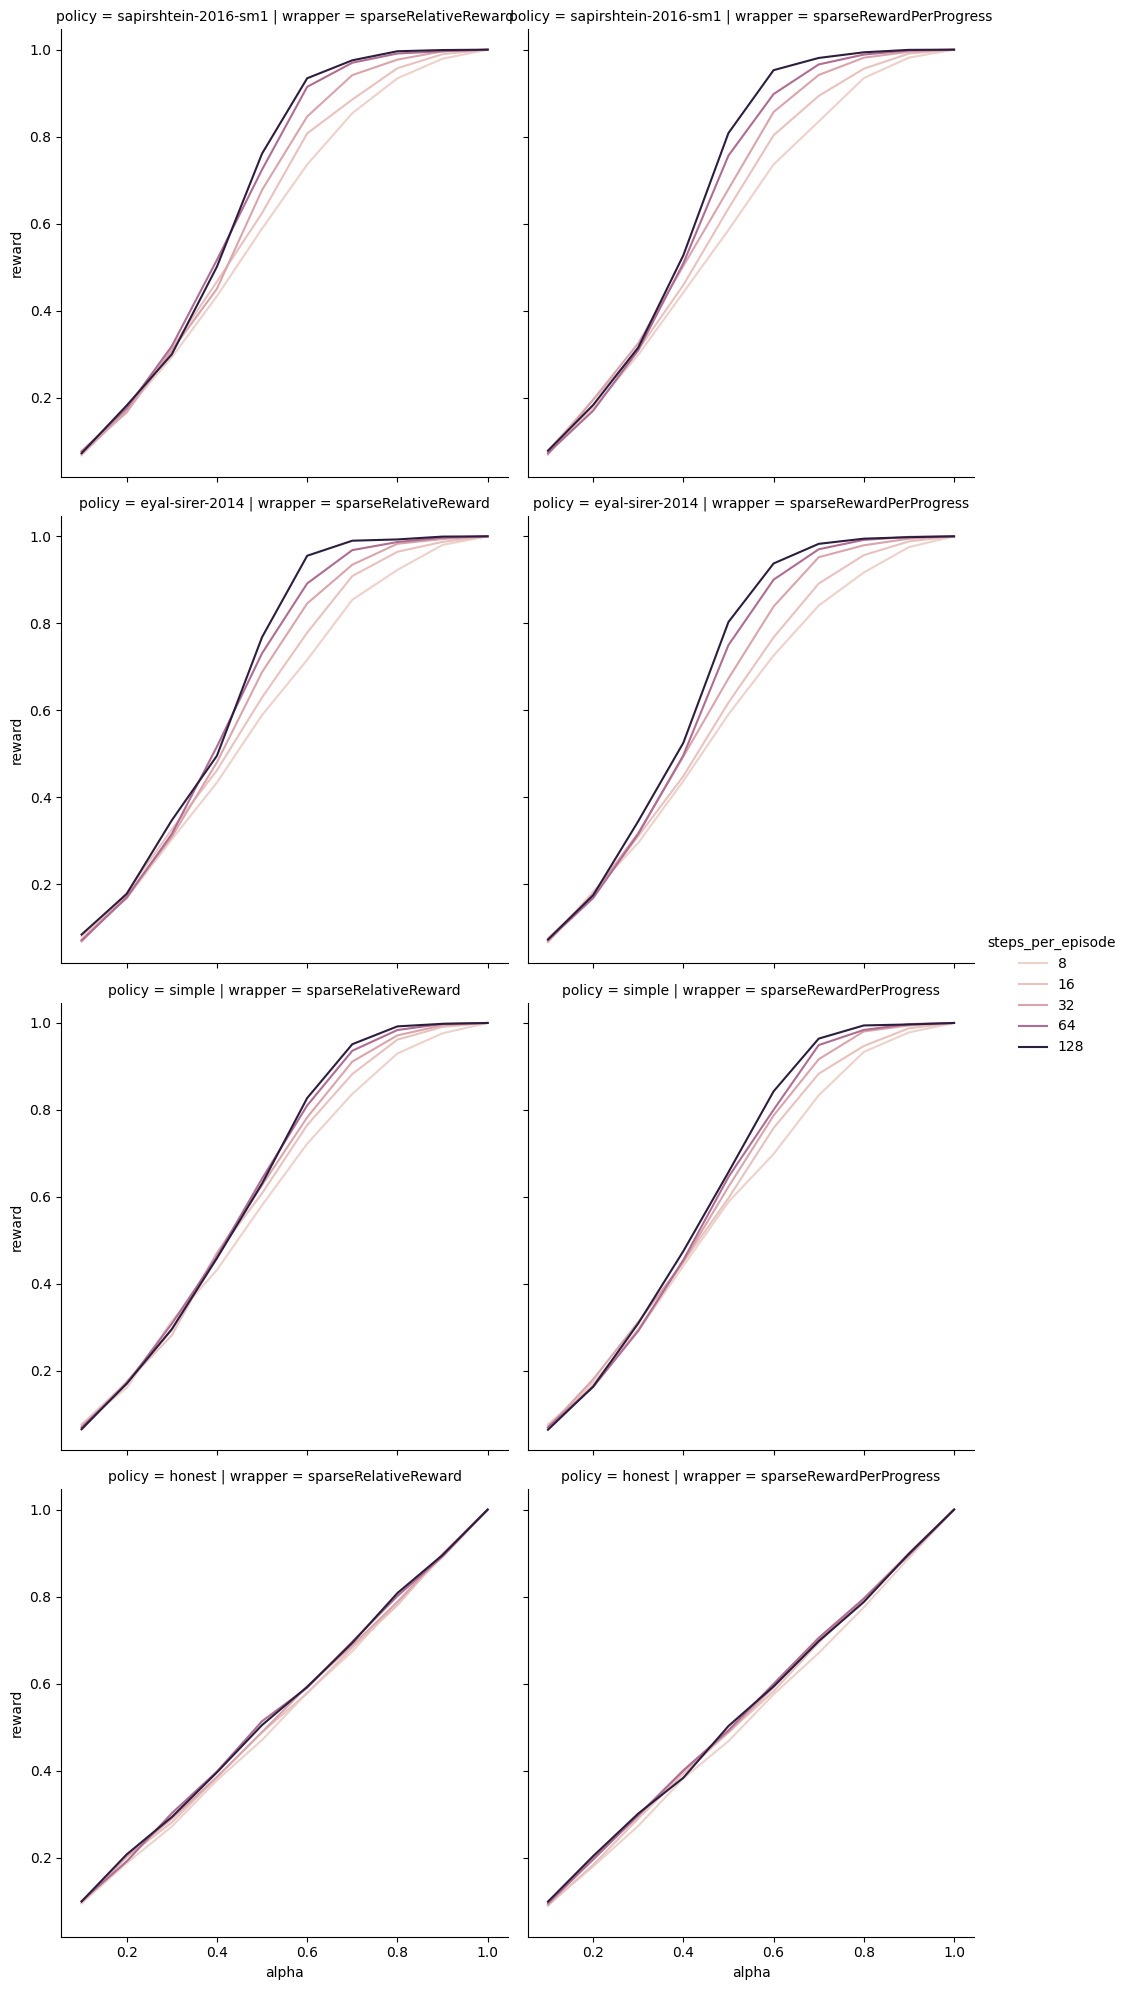

In [6]:
sns.relplot(
    data=d[d.protocol == "nakamoto"],
    kind="line",
    x="alpha",
    y="reward",
    hue="steps_per_episode",
    row="policy",
    col="wrapper",
)